#**Which Model will win?**

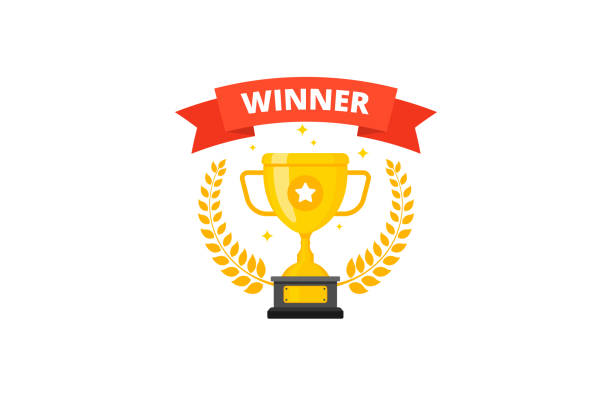

# 🤖 Time Series Forecasting Models Used

Below is a categorized list of the eight models implemented in the Python code:

---

## I. Statistical Time Series Models (ARIMA/SARIMA)

These models rely on the auto-correlation structure of the time series. The differencing term (d=1) handles the strong linear trend.

* **`ARIMA (5,1,0)`**: AutoRegressive Integrated Moving Average model. Uses non-seasonal differencing ($d=1$) to handle the trend.
* **`SARIMA (5,1,0)(0,0,0)12`**: Seasonal $\text{ARIMA}$. The seasonal component is set to zero, making it functionally identical to $\text{ARIMA}(5,1,0)$.
* **`SARIMA (1,1,0)(0,0,0)12`**: A simpler $\text{SARIMA}$ variant, using only an $\text{AR}(1)$ term on the differenced data.

---

## II. Machine Learning (ML) Regressors

These models convert the time series into a supervised learning problem using engineered features (lags and time index).

| Model Name | Features Used | Primary Function |
| :--- | :--- | :--- |
| **`XGBoost (Lags + Trend)`** | Lags (1-12) + Scaled Time Index | Flexible model, prone to overfitting the high-variance noise. |
| **`LightGBM (Lags + Trend)`** | Lags (1-12) + Scaled Time Index | Similar to $\text{XGBoost}$, but often faster; struggled with noise overfitting in the initial run. |
| **`XGBoost (Trend Only)`** | **Time Index ONLY** (Unscaled) | Forced to act as a robust linear regressor, ignoring noisy lag features. |
| **`LightGBM (Trend Only)`** | **Time Index ONLY** (Unscaled) | Same function as $\text{XGBoost}$ Trend Only: simple, noise-resistant trend estimation. |

---

## III. Specialized and Hybrid Models

These models combine different techniques for forecasting.

* **`Prophet`**: Uses a Generalized Additive Model ($\text{GAM}$) for trend. Since seasonality is disabled, its strength lies in **smooth, robust trend fitting**, making it highly resistant to the random noise.
* **`Hybrid (ARIMA+XGB)`**: A two-step model: $\text{ARIMA}$ models the trend, and $\text{XGBoost}$ attempts to forecast the $\text{ARIMA}$'s **residuals** (the remaining error/noise).
* **`STL+XGBoost`**: Uses $\text{STL}$ (Seasonal-Trend decomposition) to separate components. $\text{XGBoost}$ models the residual component, and the last known trend value is used for the long-term forecast.

##Ten years data to compare XGboost and Arrima prediction models

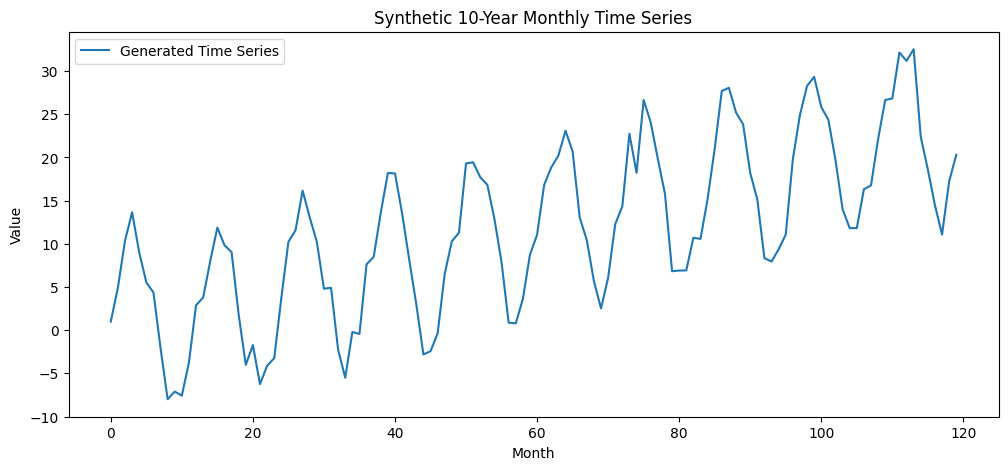

ARIMA RMSE: 6.772423126168967
XGBoost RMSE: 4.232102586905558


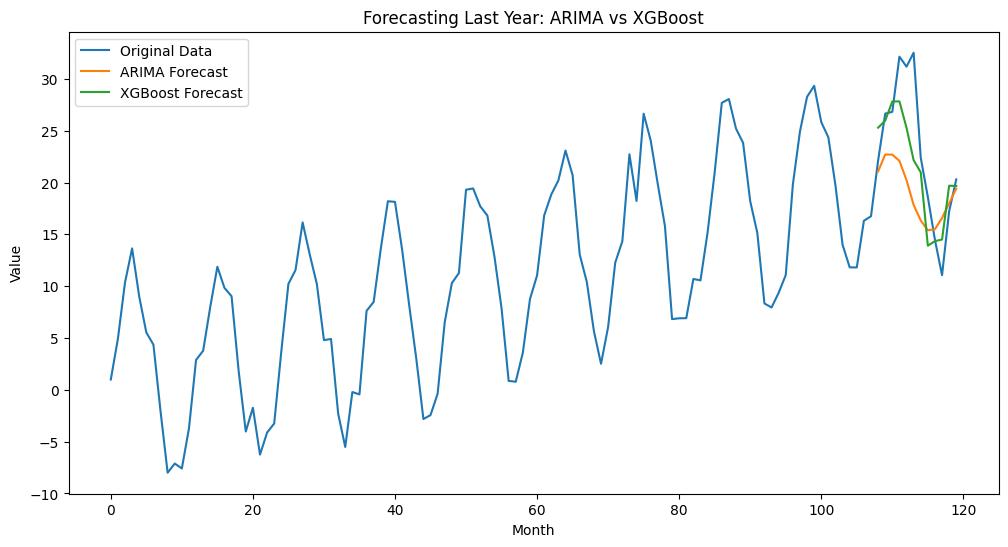

In [11]:
# Step 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA

# Step 2: Generate 10 years of monthly data (120 months)
np.random.seed(42)
n_years = 10
months = n_years * 12
time = np.arange(months)

# Linear trend
linear_trend = 0.2 * time

# Seasonal component
seasonal = 10 * np.sin(2 * np.pi * time / 12)  # yearly seasonality

# Noise
noise = np.random.normal(0, 2, months)

# Combined series
y = linear_trend + seasonal + noise

# Put into DataFrame
df = pd.DataFrame({'month': time, 'y': y})

# Plot
plt.figure(figsize=(12,5))
plt.plot(df['month'], df['y'], label='Generated Time Series')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Synthetic 10-Year Monthly Time Series')
plt.legend()
plt.show()

# --------------------------
# Step 3: Split train/test (first 9 years for training, last year for testing)
# --------------------------
train_size = 9*12
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# --------------------------
# Step 4: ARIMA model (linear + seasonal pattern)
# --------------------------
# ARIMA can handle trend but not perfect seasonality unless SARIMA is used
arima_model = ARIMA(train['y'], order=(5,1,0))
arima_fit = arima_model.fit()

# Forecast the next 12 months
arima_pred = arima_fit.forecast(steps=len(test))

print("ARIMA RMSE:", np.sqrt(mean_squared_error(test['y'], arima_pred)))

# --------------------------
# Step 5: XGBoost model (nonlinear + lag features)
# --------------------------
def create_lag_features(series, lags=12):
    df_lags = pd.DataFrame()
    for i in range(1, lags+1):
        df_lags[f'lag_{i}'] = series.shift(i)
    df_lags['y'] = series
    df_lags.dropna(inplace=True)
    return df_lags

# Combine train+test for lag features
df_lags = create_lag_features(df['y'], lags=12)

# Split into train/test
df_lags_train = df_lags[df_lags.index < train_size]
df_lags_test = df_lags[df_lags.index >= train_size]

X_train = df_lags_train.drop('y', axis=1)
y_train = df_lags_train['y']

X_test = df_lags_test.drop('y', axis=1)
y_test = df_lags_test['y']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

# --------------------------
# Step 6: Visualize
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(df['month'], df['y'], label='Original Data')
plt.plot(test['month'], arima_pred, label='ARIMA Forecast')
plt.plot(test['month'], y_pred_xgb, label='XGBoost Forecast')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Forecasting Last Year: ARIMA vs XGBoost')
plt.legend()
plt.show()


#Twenty  years data to compare XGboost and Arrima prediction models

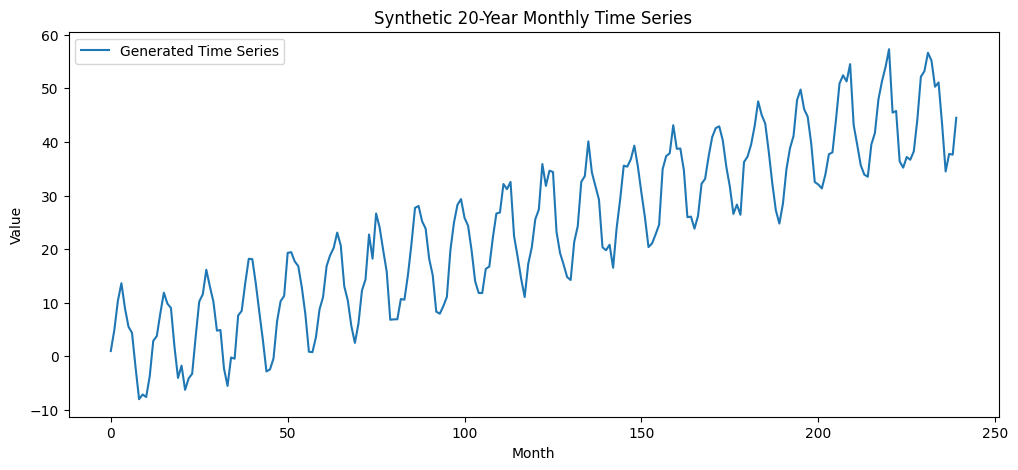

ARIMA RMSE: 7.800153858777642
XGBoost RMSE: 2.898716537811345


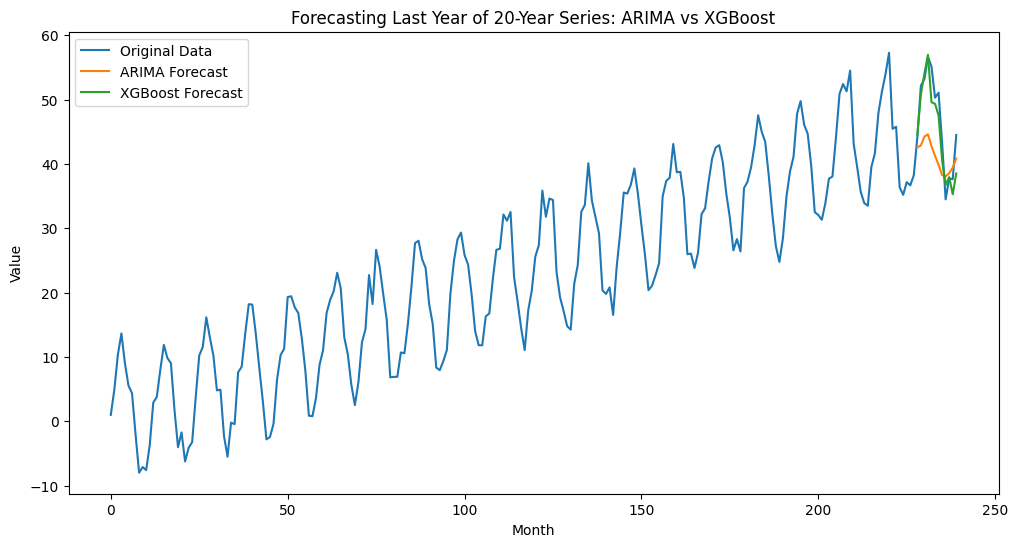

In [12]:
# Step 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA

# Step 2: Generate 20 years of monthly data (240 months)
np.random.seed(42)
n_years = 20
months = n_years * 12
time = np.arange(months)

# Linear trend
linear_trend = 0.2 * time

# Seasonal component (yearly seasonality)
seasonal = 10 * np.sin(2 * np.pi * time / 12)

# Noise
noise = np.random.normal(0, 2, months)

# Combined series
y = linear_trend + seasonal + noise

# Put into DataFrame
df = pd.DataFrame({'month': time, 'y': y})

# Plot the time series
plt.figure(figsize=(12,5))
plt.plot(df['month'], df['y'], label='Generated Time Series')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Synthetic 20-Year Monthly Time Series')
plt.legend()
plt.show()

# --------------------------
# Step 3: Split train/test (first 19 years for training, last year for testing)
# --------------------------
train_size = 19*12
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# --------------------------
# Step 4: ARIMA model (linear + seasonal pattern)
# --------------------------
arima_model = ARIMA(train['y'], order=(5,1,0))
arima_fit = arima_model.fit()

# Forecast the next 12 months
arima_pred = arima_fit.forecast(steps=len(test))

print("ARIMA RMSE:", np.sqrt(mean_squared_error(test['y'], arima_pred)))

# --------------------------
# Step 5: XGBoost model (nonlinear + lag features)
# --------------------------
def create_lag_features(series, lags=12):
    df_lags = pd.DataFrame()
    for i in range(1, lags+1):
        df_lags[f'lag_{i}'] = series.shift(i)
    df_lags['y'] = series
    df_lags.dropna(inplace=True)
    return df_lags

# Create lag features
df_lags = create_lag_features(df['y'], lags=12)

# Split into train/test
df_lags_train = df_lags[df_lags.index < train_size]
df_lags_test = df_lags[df_lags.index >= train_size]

X_train = df_lags_train.drop('y', axis=1)
y_train = df_lags_train['y']

X_test = df_lags_test.drop('y', axis=1)
y_test = df_lags_test['y']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

# --------------------------
# Step 6: Visualize
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(df['month'], df['y'], label='Original Data')
plt.plot(test['month'], arima_pred, label='ARIMA Forecast')
plt.plot(test['month'], y_pred_xgb, label='XGBoost Forecast')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Forecasting Last Year of 20-Year Series: ARIMA vs XGBoost')
plt.legend()
plt.show()


#So this confirm that the Arrima model becomes worse for large datasets but xGboost shine for large datasets

##What if we use Hybrid method

ARIMA RMSE (9-year series): 6.772
XGBoost RMSE (9-year series): 4.232
Hybrid RMSE (9-year series): 6.169


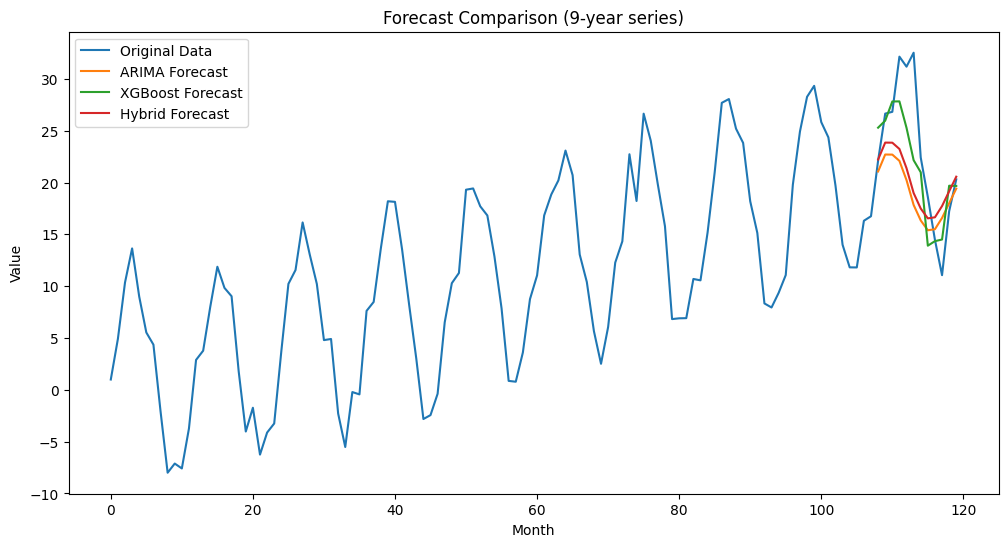

ARIMA RMSE (19-year series): 7.800
XGBoost RMSE (19-year series): 2.899
Hybrid RMSE (19-year series): 9.524


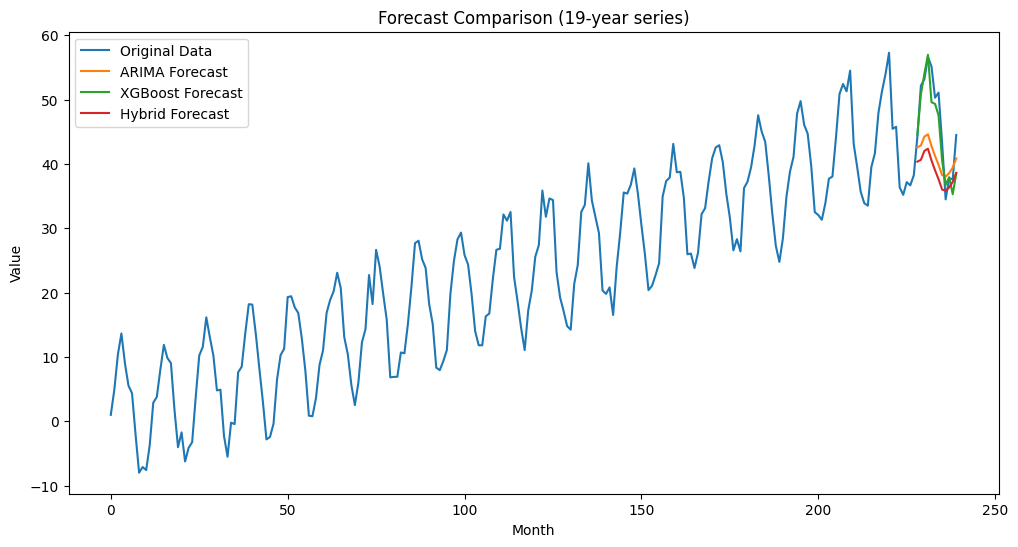

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# ----------------- Functions -----------------
def generate_data(n_years, seed=42):
    np.random.seed(seed)
    months = n_years * 12
    time = np.arange(months)
    linear_trend = 0.2 * time
    seasonal = 10 * np.sin(2 * np.pi * time / 12)
    noise = np.random.normal(0, 2, months)
    y = linear_trend + seasonal + noise
    return pd.DataFrame({'month': time, 'y': y})

def create_lag_features(series, lags=12):
    df_lags = pd.DataFrame()
    for i in range(1, lags+1):
        df_lags[f'lag_{i}'] = series.shift(i)
    df_lags['y'] = series
    df_lags.dropna(inplace=True)
    return df_lags

def forecast_models(df, n_train_years):
    train_size = n_train_years * 12
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]

    # ----------------- ARIMA -----------------
    arima_model = ARIMA(train['y'], order=(5,1,0))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(test))
    arima_rmse = np.sqrt(mean_squared_error(test['y'], arima_forecast))
    print(f"ARIMA RMSE ({n_train_years}-year series): {arima_rmse:.3f}")

    # ----------------- XGBoost -----------------
    df_lags = create_lag_features(df['y'], lags=12)
    df_train_lags = df_lags[df_lags.index < train_size]
    df_test_lags = df_lags[df_lags.index >= train_size]

    X_train = df_train_lags.drop('y', axis=1)
    y_train = df_train_lags['y']
    X_test = df_test_lags.drop('y', axis=1)
    y_test = df_test_lags['y']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
    xgb_model.fit(X_train_scaled, y_train)
    xgb_forecast = xgb_model.predict(X_test_scaled)
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_forecast))
    print(f"XGBoost RMSE ({n_train_years}-year series): {xgb_rmse:.3f}")

    # ----------------- Hybrid (ARIMA + XGBoost residuals) -----------------
    arima_pred_train = arima_fit.fittedvalues
    residuals = train['y'].iloc[1:] - arima_pred_train  # for d=1

    df_resid = create_lag_features(residuals, lags=12)
    X_resid_train = df_resid.drop('y', axis=1)
    y_resid_train = df_resid['y']

    combined_series = pd.concat([train['y'], test['y']])
    df_resid_test = create_lag_features(combined_series, lags=12)
    df_resid_test = df_resid_test[df_resid_test.index >= train_size]
    X_resid_test = df_resid_test.drop('y', axis=1)

    scaler_resid = StandardScaler()
    X_resid_train_scaled = scaler_resid.fit_transform(X_resid_train)
    X_resid_test_scaled = scaler_resid.transform(X_resid_test)

    xgb_resid_model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
    xgb_resid_model.fit(X_resid_train_scaled, y_resid_train)
    resid_forecast = xgb_resid_model.predict(X_resid_test_scaled)

    hybrid_forecast = arima_forecast.values + resid_forecast
    hybrid_rmse = np.sqrt(mean_squared_error(test['y'], hybrid_forecast))
    print(f"Hybrid RMSE ({n_train_years}-year series): {hybrid_rmse:.3f}")

    # ----------------- Plot -----------------
    plt.figure(figsize=(12,6))
    plt.plot(df['month'], df['y'], label='Original Data')
    plt.plot(test['month'], arima_forecast, label='ARIMA Forecast')
    plt.plot(test['month'], xgb_forecast, label='XGBoost Forecast')
    plt.plot(test['month'], hybrid_forecast, label='Hybrid Forecast')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.title(f'Forecast Comparison ({n_train_years}-year series)')
    plt.legend()
    plt.show()


# ----------------- Run for 10-year series -----------------
df_10y = generate_data(10)
forecast_models(df_10y, n_train_years=9)

# ----------------- Run for 20-year series -----------------
df_20y = generate_data(20)
forecast_models(df_20y, n_train_years=19)


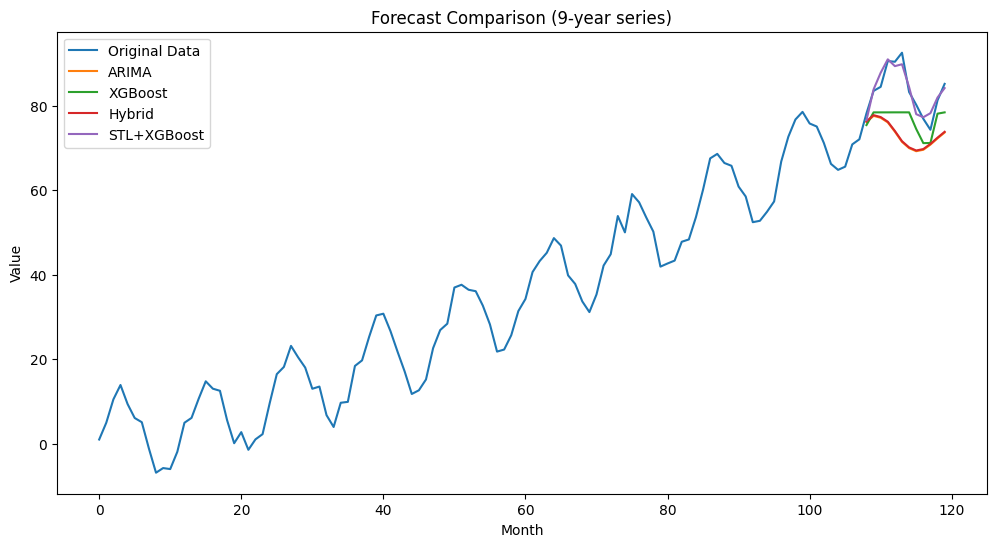

ARIMA RMSE: 11.552
XGBoost RMSE: 7.720
Hybrid RMSE: 11.403
STL+XGBoost RMSE: 1.957


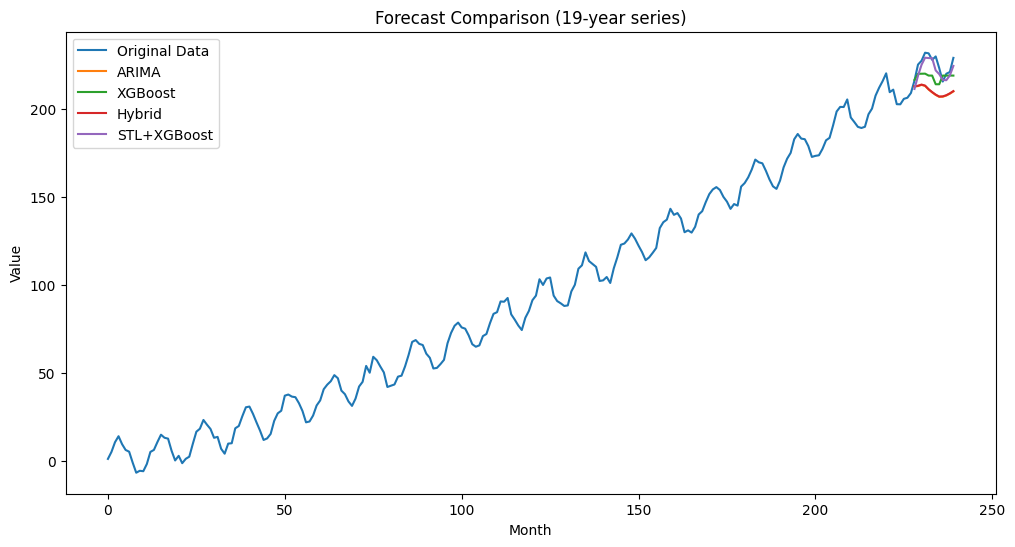

ARIMA RMSE: 15.722
XGBoost RMSE: 8.747
Hybrid RMSE: 15.554
STL+XGBoost RMSE: 4.071


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# ----------------- Data Generation -----------------
def generate_data(n_years, seed=42):
    np.random.seed(seed)
    months = n_years * 12
    time = np.arange(months)
    linear_trend = 0.2 * time
    seasonal = 10 * np.sin(2 * np.pi * time / 12)
    nonlinear = 0.05 * time**1.5
    noise = np.random.normal(0, 2, months)
    y = linear_trend + seasonal + nonlinear + noise
    return pd.DataFrame({'month': time, 'y': y})

# ----------------- Lag Features -----------------
def create_lag_features(series, lags=12):
    df_lags = pd.DataFrame()
    for i in range(1, lags+1):
        df_lags[f'lag_{i}'] = series.shift(i)
    df_lags['y'] = series
    df_lags.dropna(inplace=True)
    return df_lags

# ----------------- Forecasting Function -----------------
def compare_models(df, n_train_years):
    train_size = n_train_years * 12
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]

    results = {}

    # ----------------- ARIMA -----------------
    arima_model = ARIMA(train['y'], order=(5,1,0))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(test))
    results['ARIMA'] = np.sqrt(mean_squared_error(test['y'], arima_forecast))

    # ----------------- XGBoost -----------------
    df_lags = create_lag_features(df['y'], lags=12)
    df_train_lags = df_lags[df_lags.index < train_size]
    df_test_lags = df_lags[df_lags.index >= train_size]

    X_train = df_train_lags.drop('y', axis=1)
    y_train = df_train_lags['y']
    X_test = df_test_lags.drop('y', axis=1)
    y_test = df_test_lags['y']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
    xgb_model.fit(X_train_scaled, y_train)
    xgb_forecast = xgb_model.predict(X_test_scaled)
    results['XGBoost'] = np.sqrt(mean_squared_error(y_test, xgb_forecast))

    # ----------------- Hybrid ARIMA + XGBoost Residuals -----------------
    arima_pred_train = arima_fit.fittedvalues
    residuals = train['y'].iloc[1:] - arima_pred_train  # d=1 adjustment

    df_resid = create_lag_features(residuals, lags=12)
    X_resid_train = df_resid.drop('y', axis=1)
    y_resid_train = df_resid['y']

    combined_series = pd.concat([train['y'], test['y']])
    df_resid_test = create_lag_features(combined_series, lags=12)
    df_resid_test = df_resid_test[df_resid_test.index >= train_size]
    X_resid_test = df_resid_test.drop('y', axis=1)

    scaler_resid = StandardScaler()
    X_resid_train_scaled = scaler_resid.fit_transform(X_resid_train)
    X_resid_test_scaled = scaler_resid.transform(X_resid_test)

    xgb_resid_model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
    xgb_resid_model.fit(X_resid_train_scaled, y_resid_train)
    resid_forecast = xgb_resid_model.predict(X_resid_test_scaled)

    hybrid_forecast = arima_forecast.values + resid_forecast
    results['Hybrid'] = np.sqrt(mean_squared_error(test['y'], hybrid_forecast))

    # ----------------- STL + XGBoost -----------------
    stl = STL(train['y'], period=12)
    res = stl.fit()
    trend = res.trend
    seasonal = res.seasonal
    resid = res.resid

    df_resid_stl = create_lag_features(resid, lags=12)
    X_train_stl = df_resid_stl.drop('y', axis=1)
    y_train_stl = df_resid_stl['y']

    # Test residuals
    combined_resid = pd.concat([train['y'], test['y']])
    stl_combined = STL(combined_resid, period=12).fit()
    resid_combined = stl_combined.resid
    df_resid_test_stl = create_lag_features(resid_combined, lags=12)
    df_resid_test_stl = df_resid_test_stl[df_resid_test_stl.index >= train_size]
    X_test_stl = df_resid_test_stl.drop('y', axis=1)

    scaler_stl = StandardScaler()
    X_train_stl_scaled = scaler_stl.fit_transform(X_train_stl)
    X_test_stl_scaled = scaler_stl.transform(X_test_stl)

    xgb_stl_model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
    xgb_stl_model.fit(X_train_stl_scaled, y_train_stl)
    resid_forecast_stl = xgb_stl_model.predict(X_test_stl_scaled)

    # Forecast trend + seasonality from last train month
    last_trend = trend.iloc[-1]
    trend_forecast = np.linspace(last_trend, last_trend + (trend.iloc[-1]-trend.iloc[-2])*len(test), len(test))
    seasonal_forecast = seasonal.iloc[-12:].values  # repeating last year
    seasonal_forecast = np.tile(seasonal_forecast, int(np.ceil(len(test)/12)))[:len(test)]

    stl_forecast = trend_forecast + seasonal_forecast + resid_forecast_stl
    results['STL+XGBoost'] = np.sqrt(mean_squared_error(test['y'], stl_forecast))

    # ----------------- Plot -----------------
    plt.figure(figsize=(12,6))
    plt.plot(df['month'], df['y'], label='Original Data')
    plt.plot(test['month'], arima_forecast, label='ARIMA')
    plt.plot(test['month'], xgb_forecast, label='XGBoost')
    plt.plot(test['month'], hybrid_forecast, label='Hybrid')
    plt.plot(test['month'], stl_forecast, label='STL+XGBoost')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.title(f'Forecast Comparison ({n_train_years}-year series)')
    plt.legend()
    plt.show()

    for model, rmse in results.items():
        print(f"{model} RMSE: {rmse:.3f}")

# ----------------- Run for 10-year series -----------------
df_10y = generate_data(10)
compare_models(df_10y, n_train_years=9)

# ----------------- Run for 20-year series -----------------
df_20y = generate_data(20)
compare_models(df_20y, n_train_years=19)


## For data with no trends and only seasonality

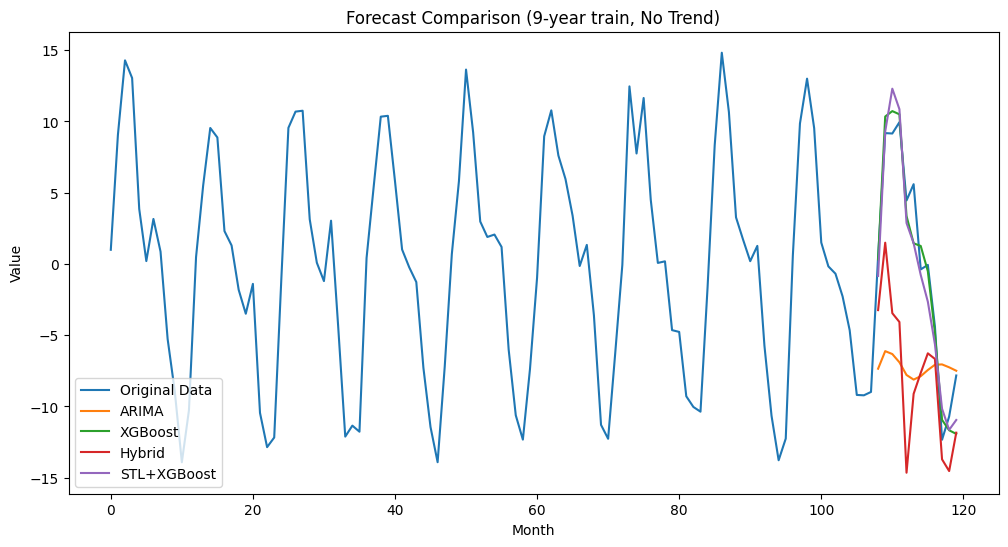

ARIMA RMSE: 10.468
XGBoost RMSE: 1.944
Hybrid RMSE: 9.743
STL+XGBoost RMSE: 2.159


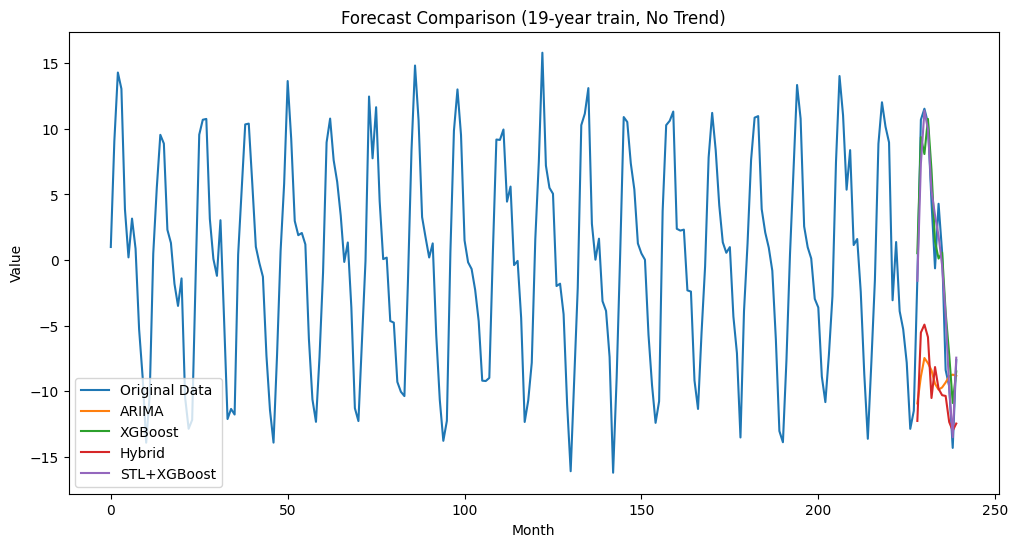

ARIMA RMSE: 12.081
XGBoost RMSE: 2.627
Hybrid RMSE: 11.365
STL+XGBoost RMSE: 2.118


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# ----------------- Data Generation (No Trend) -----------------
def generate_no_trend_data(n_years, seed=42):
    np.random.seed(seed)
    months = n_years * 12
    time = np.arange(months)

    # Pure seasonal + noise (no trend)
    seasonal = 10 * np.sin(2 * np.pi * time / 12)
    seasonal += 5 * np.sin(2 * np.pi * time / 6)  # optional second seasonal component
    noise = np.random.normal(0, 2, months)

    y = seasonal + noise
    return pd.DataFrame({'month': time, 'y': y})

# ----------------- Lag Features -----------------
def create_lag_features(series, lags=12):
    df_lags = pd.DataFrame()
    for i in range(1, lags+1):
        df_lags[f'lag_{i}'] = series.shift(i)
    df_lags['y'] = series
    df_lags.dropna(inplace=True)
    return df_lags

# ----------------- Forecasting Function -----------------
def compare_models(df, n_train_years):
    train_size = n_train_years * 12
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]

    results = {}

    # ----------------- ARIMA -----------------
    arima_model = ARIMA(train['y'], order=(5,1,0))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(test))
    results['ARIMA'] = np.sqrt(mean_squared_error(test['y'], arima_forecast))

    # ----------------- XGBoost -----------------
    df_lags = create_lag_features(df['y'], lags=12)
    df_train_lags = df_lags[df_lags.index < train_size]
    df_test_lags = df_lags[df_lags.index >= train_size]

    X_train = df_train_lags.drop('y', axis=1)
    y_train = df_train_lags['y']
    X_test = df_test_lags.drop('y', axis=1)
    y_test = df_test_lags['y']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
    xgb_model.fit(X_train_scaled, y_train)
    xgb_forecast = xgb_model.predict(X_test_scaled)
    results['XGBoost'] = np.sqrt(mean_squared_error(y_test, xgb_forecast))

    # ----------------- Hybrid ARIMA + XGBoost Residuals -----------------
    arima_pred_train = arima_fit.fittedvalues
    residuals = train['y'].iloc[1:] - arima_pred_train  # d=1 adjustment

    df_resid = create_lag_features(residuals, lags=12)
    X_resid_train = df_resid.drop('y', axis=1)
    y_resid_train = df_resid['y']

    combined_series = pd.concat([train['y'], test['y']])
    df_resid_test = create_lag_features(combined_series, lags=12)
    df_resid_test = df_resid_test[df_resid_test.index >= train_size]
    X_resid_test = df_resid_test.drop('y', axis=1)

    scaler_resid = StandardScaler()
    X_resid_train_scaled = scaler_resid.fit_transform(X_resid_train)
    X_resid_test_scaled = scaler_resid.transform(X_resid_test)

    xgb_resid_model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
    xgb_resid_model.fit(X_resid_train_scaled, y_resid_train)
    resid_forecast = xgb_resid_model.predict(X_resid_test_scaled)

    hybrid_forecast = arima_forecast.values + resid_forecast
    results['Hybrid'] = np.sqrt(mean_squared_error(test['y'], hybrid_forecast))

    # ----------------- STL + XGBoost -----------------
    stl = STL(train['y'], period=12)
    res = stl.fit()
    seasonal = res.seasonal
    resid = res.resid

    df_resid_stl = create_lag_features(resid, lags=12)
    X_train_stl = df_resid_stl.drop('y', axis=1)
    y_train_stl = df_resid_stl['y']

    combined_resid = pd.concat([train['y'], test['y']])
    stl_combined = STL(combined_resid, period=12).fit()
    resid_combined = stl_combined.resid
    df_resid_test_stl = create_lag_features(resid_combined, lags=12)
    df_resid_test_stl = df_resid_test_stl[df_resid_test_stl.index >= train_size]
    X_test_stl = df_resid_test_stl.drop('y', axis=1)

    scaler_stl = StandardScaler()
    X_train_stl_scaled = scaler_stl.fit_transform(X_train_stl)
    X_test_stl_scaled = scaler_stl.transform(X_test_stl)

    xgb_stl_model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
    xgb_stl_model.fit(X_train_stl_scaled, y_train_stl)
    resid_forecast_stl = xgb_stl_model.predict(X_test_stl_scaled)

    # Forecast seasonal component
    seasonal_forecast = seasonal.iloc[-12:].values
    seasonal_forecast = np.tile(seasonal_forecast, int(np.ceil(len(test)/12)))[:len(test)]

    stl_forecast = seasonal_forecast + resid_forecast_stl
    results['STL+XGBoost'] = np.sqrt(mean_squared_error(test['y'], stl_forecast))

    # ----------------- Plot -----------------
    plt.figure(figsize=(12,6))
    plt.plot(df['month'], df['y'], label='Original Data')
    plt.plot(test['month'], arima_forecast, label='ARIMA')
    plt.plot(test['month'], xgb_forecast, label='XGBoost')
    plt.plot(test['month'], hybrid_forecast, label='Hybrid')
    plt.plot(test['month'], stl_forecast, label='STL+XGBoost')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.title(f'Forecast Comparison ({n_train_years}-year train, No Trend)')
    plt.legend()
    plt.show()

    for model, rmse in results.items():
        print(f"{model} RMSE: {rmse:.3f}")

# ----------------- Run for 10-year series -----------------
df_10y = generate_no_trend_data(10)
compare_models(df_10y, n_train_years=9)

# ----------------- Run for 20-year series -----------------
df_20y = generate_no_trend_data(20)
compare_models(df_20y, n_train_years=19)


In [39]:
!pip uninstall Prophet -y

Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7


In [41]:
!pip install Prophet==1.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 20.8 MB/s eta 0:00:00


## Pure seasonality

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 96, number of used features: 12
[LightGBM] [Info] Start training from score -0.304450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

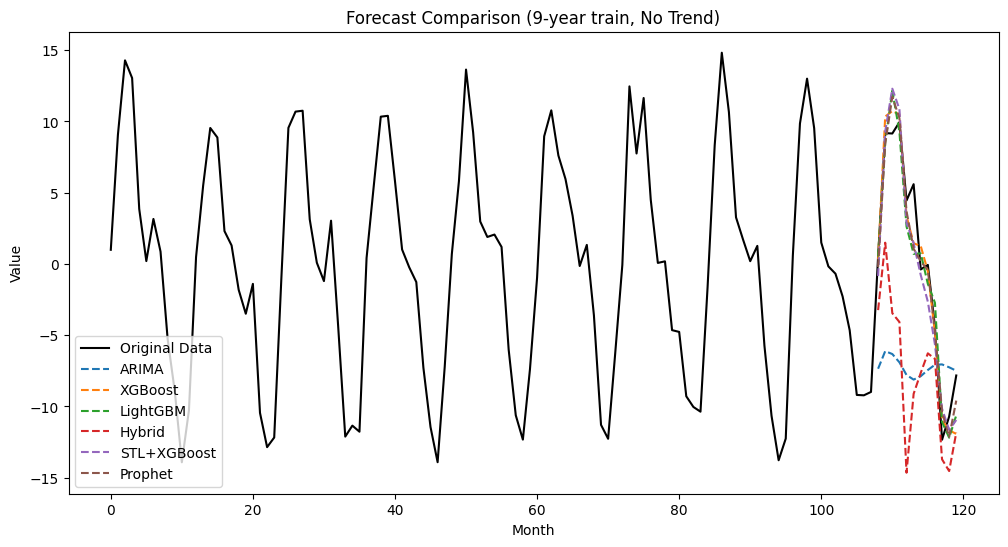

ARIMA RMSE: 10.468
XGBoost RMSE: 1.944
LightGBM RMSE: 2.131
Hybrid RMSE: 9.743
STL+XGBoost RMSE: 2.159
Prophet RMSE: 1.791
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 12
[LightGBM] [Info] Start training from score -0.037983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

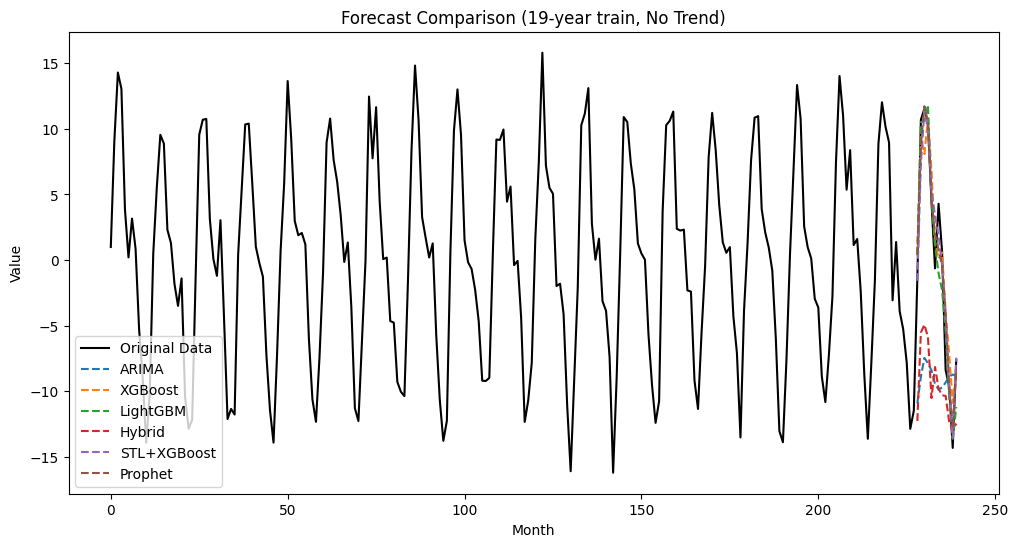

ARIMA RMSE: 12.081
XGBoost RMSE: 2.627
LightGBM RMSE: 2.372
Hybrid RMSE: 11.365
STL+XGBoost RMSE: 2.118
Prophet RMSE: 2.003


In [43]:
# !pip install prophet lightgbm xgboost statsmodels scikit-learn matplotlib pandas numpy --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['CMDSTAN'] = "C:/Anaconda/Anaconda3/envs/test_conda_env/Library/bin/cmdstan"

from prophet import Prophet
#m = Prophet()
# ----------------- Data Generation (No Trend) -----------------
def generate_no_trend_data(n_years, seed=42):
    np.random.seed(seed)
    months = n_years * 12
    time = np.arange(months)
    seasonal = 10 * np.sin(2 * np.pi * time / 12)
    seasonal += 5 * np.sin(2 * np.pi * time / 6)
    noise = np.random.normal(0, 2, months)
    y = seasonal + noise
    return pd.DataFrame({'month': time, 'y': y})

# ----------------- Lag Features -----------------
def create_lag_features(series, lags=12):
    df_lags = pd.DataFrame()
    for i in range(1, lags + 1):
        df_lags[f'lag_{i}'] = series.shift(i)
    df_lags['y'] = series
    df_lags.dropna(inplace=True)
    return df_lags

# ----------------- Forecasting Function -----------------
def compare_models_extended(df, n_train_years):
    train_size = n_train_years * 12
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    results = {}

    # ----------------- ARIMA -----------------
    arima_model = ARIMA(train['y'], order=(5, 1, 0))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(test))
    results['ARIMA'] = np.sqrt(mean_squared_error(test['y'], arima_forecast))

    # ----------------- XGBoost -----------------
    df_lags = create_lag_features(df['y'], lags=12)
    df_train_lags = df_lags[df_lags.index < train_size]
    df_test_lags = df_lags[df_lags.index >= train_size]

    X_train = df_train_lags.drop('y', axis=1)
    y_train = df_train_lags['y']
    X_test = df_test_lags.drop('y', axis=1)
    y_test = df_test_lags['y']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)
    xgb_forecast = xgb_model.predict(X_test_scaled)
    results['XGBoost'] = np.sqrt(mean_squared_error(y_test, xgb_forecast))

    # ----------------- LightGBM -----------------
    lgb_model = LGBMRegressor(n_estimators=200, random_state=42)
    lgb_model.fit(X_train_scaled, y_train)
    lgb_forecast = lgb_model.predict(X_test_scaled)
    results['LightGBM'] = np.sqrt(mean_squared_error(y_test, lgb_forecast))

    # ----------------- Hybrid ARIMA + XGBoost Residuals -----------------
    arima_pred_train = arima_fit.fittedvalues
    residuals = train['y'].iloc[1:] - arima_pred_train  # d=1 adjustment

    df_resid = create_lag_features(residuals, lags=12)
    X_resid_train = df_resid.drop('y', axis=1)
    y_resid_train = df_resid['y']

    combined_series = pd.concat([train['y'], test['y']])
    df_resid_test = create_lag_features(combined_series, lags=12)
    df_resid_test = df_resid_test[df_resid_test.index >= train_size]
    X_resid_test = df_resid_test.drop('y', axis=1)

    scaler_resid = StandardScaler()
    X_resid_train_scaled = scaler_resid.fit_transform(X_resid_train)
    X_resid_test_scaled = scaler_resid.transform(X_resid_test)

    xgb_resid_model = XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
    xgb_resid_model.fit(X_resid_train_scaled, y_resid_train)
    resid_forecast = xgb_resid_model.predict(X_resid_test_scaled)
    hybrid_forecast = arima_forecast.values + resid_forecast
    results['Hybrid'] = np.sqrt(mean_squared_error(test['y'], hybrid_forecast))

    # ----------------- STL + XGBoost -----------------
    stl = STL(train['y'], period=12)
    res = stl.fit()
    seasonal = res.seasonal
    resid = res.resid

    df_resid_stl = create_lag_features(resid, lags=12)
    X_train_stl = df_resid_stl.drop('y', axis=1)
    y_train_stl = df_resid_stl['y']

    combined_resid = pd.concat([train['y'], test['y']])
    stl_combined = STL(combined_resid, period=12).fit()
    resid_combined = stl_combined.resid
    df_resid_test_stl = create_lag_features(resid_combined, lags=12)
    df_resid_test_stl = df_resid_test_stl[df_resid_test_stl.index >= train_size]
    X_test_stl = df_resid_test_stl.drop('y', axis=1)

    scaler_stl = StandardScaler()
    X_train_stl_scaled = scaler_stl.fit_transform(X_train_stl)
    X_test_stl_scaled = scaler_stl.transform(X_test_stl)

    xgb_stl_model = XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
    xgb_stl_model.fit(X_train_stl_scaled, y_train_stl)
    resid_forecast_stl = xgb_stl_model.predict(X_test_stl_scaled)

    seasonal_forecast = seasonal.iloc[-12:].values
    seasonal_forecast = np.tile(seasonal_forecast, int(np.ceil(len(test) / 12)))[:len(test)]
    stl_forecast = seasonal_forecast + resid_forecast_stl
    results['STL+XGBoost'] = np.sqrt(mean_squared_error(test['y'], stl_forecast))

    # ----------------- Prophet -----------------
    prophet_train = pd.DataFrame({
        'ds': pd.date_range(start='2000-01-01', periods=len(train), freq='MS'),
        'y': train['y'].values
    })
    # **FIX APPLIED HERE**: Explicitly set stan_backend=None
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        stan_backend=None
    )
    prophet_model.fit(prophet_train)

    future = prophet_model.make_future_dataframe(periods=len(test), freq='MS')
    forecast = prophet_model.predict(future)
    prophet_forecast = forecast['yhat'].iloc[-len(test):].values
    results['Prophet'] = np.sqrt(mean_squared_error(test['y'], prophet_forecast))

    # ----------------- Plot -----------------
    plt.figure(figsize=(12, 6))
    plt.plot(df['month'], df['y'], label='Original Data', color='black')
    plt.plot(test['month'], arima_forecast, label='ARIMA', linestyle='--')
    plt.plot(test['month'], xgb_forecast, label='XGBoost', linestyle='--')
    plt.plot(test['month'], lgb_forecast, label='LightGBM', linestyle='--')
    plt.plot(test['month'], hybrid_forecast, label='Hybrid', linestyle='--')
    plt.plot(test['month'], stl_forecast, label='STL+XGBoost', linestyle='--')
    plt.plot(test['month'], prophet_forecast, label='Prophet', linestyle='--')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.title(f'Forecast Comparison ({n_train_years}-year train, No Trend)')
    plt.legend()
    plt.show()

    for model, rmse in results.items():
        print(f"{model} RMSE: {rmse:.3f}")

# ----------------- Run for 10-year and 20-year series -----------------
df_10y = generate_no_trend_data(10)
compare_models_extended(df_10y, n_train_years=9)

df_20y = generate_no_trend_data(20)
compare_models_extended(df_20y, n_train_years=19)

Starting comparison for 10-year series...


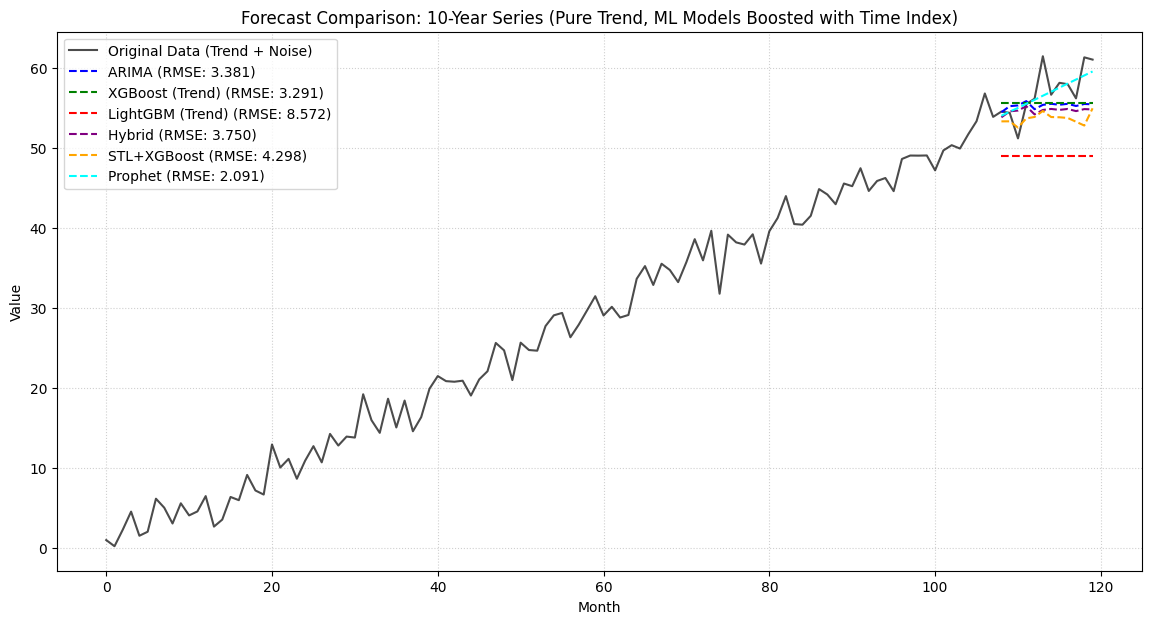


--- 10-Year Series RMSE Scores (Pure Trend, ML Boosted) ---
Prophet RMSE: 2.091
XGBoost (Trend) RMSE: 3.291
ARIMA RMSE: 3.381
Hybrid RMSE: 3.750
STL+XGBoost RMSE: 4.298
LightGBM (Trend) RMSE: 8.572
----------------------------------------

Starting comparison for 20-year series...


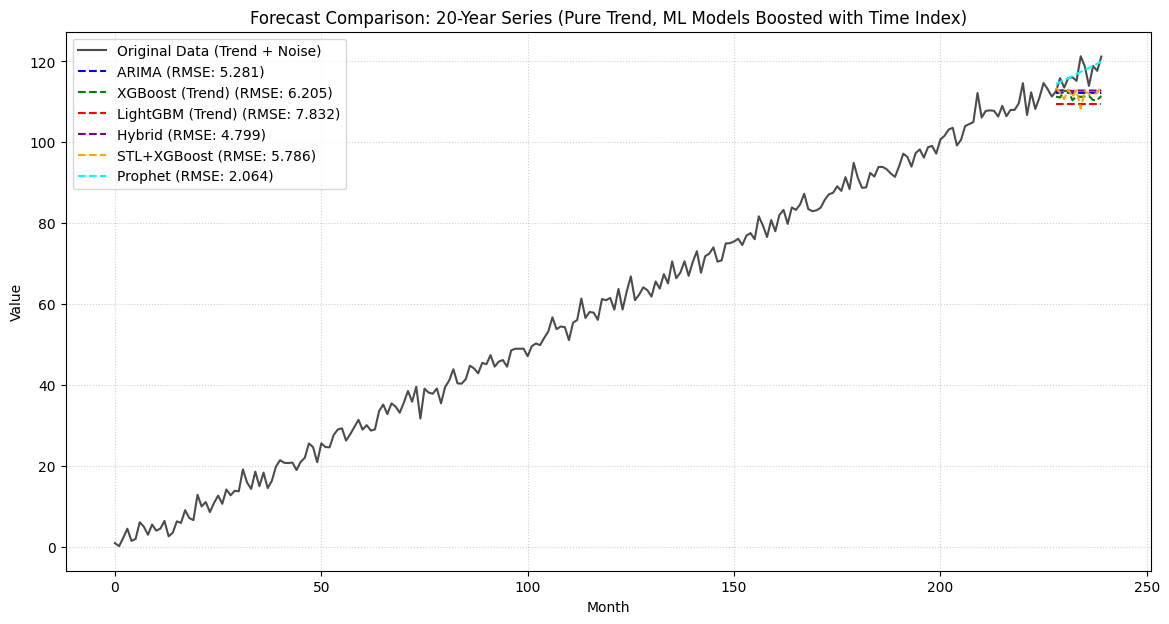


--- 20-Year Series RMSE Scores (Pure Trend, ML Boosted) ---
Prophet RMSE: 2.064
Hybrid RMSE: 4.799
ARIMA RMSE: 5.281
STL+XGBoost RMSE: 5.786
XGBoost (Trend) RMSE: 6.205
LightGBM (Trend) RMSE: 7.832
----------------------------------------


{'ARIMA': np.float64(5.281319419803174),
 'XGBoost (Trend)': np.float64(6.204586416334109),
 'LightGBM (Trend)': np.float64(7.8322382743095575),
 'Hybrid': np.float64(4.799193886224823),
 'STL+XGBoost': np.float64(5.785908097268619),
 'Prophet': np.float64(2.0641426208909963)}

In [47]:
# Install necessary libraries (uncomment if running outside an environment where they are pre-installed)
# !pip install prophet lightgbm xgboost statsmodels scikit-learn matplotlib pandas numpy --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Prophet uses Stan/CmdStan which sometimes needs environment configuration.
# If you encounter issues, you might need to adjust this path or configuration
# os.environ['CMDSTAN'] = "C:/Anaconda/Anaconda3/envs/test_conda_env/Library/bin/cmdstan"


# ----------------- 1. Data Generation (Pure Trend) -----------------
def generate_pure_trend_data(n_years, seed=42):
    """
    Generates synthetic time series data consisting only of a linear trend and noise.
    No seasonal component is included.
    """
    np.random.seed(seed)
    months = n_years * 12
    time = np.arange(months)

    # Simple linear trend (0.5 increase per month)
    trend = 0.5 * time

    # Gaussian noise
    noise = np.random.normal(0, 2, months) # Standard deviation (sigma) = 2

    # Final series is Trend + Noise
    y = trend + noise
    return pd.DataFrame({'month': time, 'y': y})


# ----------------- 2. Utility: Lag Features -----------------
def create_lag_features(df, lags=12):
    """
    Creates lagged features and adds the 'time_index' as an explicit feature.
    """
    series = df['y']
    df_lags = pd.DataFrame(index=df.index)

    # Add the explicit time index (trend feature)
    df_lags['time_index'] = df['month']

    # Add lag features
    for i in range(1, lags + 1):
        df_lags[f'lag_{i}'] = series.shift(i)

    df_lags['y'] = series
    df_lags.dropna(inplace=True)
    return df_lags


# ----------------- 3. Forecasting Function -----------------
def compare_models_extended(df, n_train_years, title_suffix):
    """
    Splits data, trains six different forecasting models, calculates RMSE, and plots the results.
    """
    total_months = len(df)
    train_size = n_train_years * 12
    test_size = total_months - train_size

    # Ensure there is enough data for testing and lagging
    if train_size <= 12 or test_size < 1:
        print(f"Error: Not enough data for training or testing with {n_train_years} years of training.")
        return

    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    results = {}

    # --- Setup for ML Models (Lags + TIME_INDEX) ---
    # NOTE: The create_lag_features function now includes 'time_index'
    df_lags = create_lag_features(df, lags=12)

    # Adjust train/test indices based on lag dropna (first 12 rows are dropped)
    start_lag_index = df_lags.index[0]
    df_train_lags = df_lags[df_lags.index < train_size]
    df_test_lags = df_lags[df_lags.index >= train_size]

    X_train = df_train_lags.drop('y', axis=1)
    y_train = df_train_lags['y']
    X_test = df_test_lags.drop('y', axis=1)
    y_test = df_test_lags['y']

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ----------------- ARIMA -----------------
    # ARIMA(p=5, d=1, q=0) - using differencing d=1 to handle the trend
    arima_model = ARIMA(train['y'], order=(5, 1, 0))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(test))
    results['ARIMA'] = np.sqrt(mean_squared_error(test['y'], arima_forecast))

    # ----------------- XGBoost (Explicit Trend) -----------------
    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)
    xgb_forecast = xgb_model.predict(X_test_scaled)
    results['XGBoost (Trend)'] = np.sqrt(mean_squared_error(y_test, xgb_forecast))

    # ----------------- LightGBM (Explicit Trend) -----------------
    lgb_model = LGBMRegressor(n_estimators=200, random_state=42, verbose=-1) # verbose=-1 to suppress warnings
    lgb_model.fit(X_train_scaled, y_train)
    lgb_forecast = lgb_model.predict(X_test_scaled)
    results['LightGBM (Trend)'] = np.sqrt(mean_squared_error(y_test, lgb_forecast))

    # ----------------- Hybrid ARIMA + XGBoost Residuals -----------------
    # This Hybrid is kept the same, as it relies on ARIMA's intrinsic differencing
    # 1. Get ARIMA fitted values and calculate residuals
    arima_pred_train = arima_fit.fittedvalues
    # Account for differencing (d=1) which shortens the fitted values by 1
    residuals = train['y'].iloc[1:] - arima_pred_train

    # 2. Prepare features for XGBoost on residuals - Use only Lags for residuals
    df_resid = create_lag_features(pd.DataFrame({'y': residuals, 'month': residuals.index}), lags=12)
    X_resid_train = df_resid.drop('y', axis=1)
    y_resid_train = df_resid['y']

    # Remove the explicit time_index feature for residual modeling
    X_resid_train = X_resid_train.drop('time_index', axis=1)

    # Create test features by lagging the *full* series up to the test start
    combined_series = pd.concat([train['y'], test['y']])
    # We must use the simpler lag-only version of create_lag_features here
    def create_lag_features_only(series, lags=12):
        df_lags = pd.DataFrame()
        for i in range(1, lags + 1):
            df_lags[f'lag_{i}'] = series.shift(i)
        df_lags['y'] = series
        df_lags.dropna(inplace=True)
        return df_lags

    df_resid_test_raw = create_lag_features_only(combined_series, lags=12)
    df_resid_test = df_resid_test_raw.iloc[train_size - 12:train_size - 12 + len(test)].drop('y', axis=1)
    X_resid_test = df_resid_test

    # 3. Scale and train XGBoost on residuals
    scaler_resid = StandardScaler()
    X_resid_train_scaled = scaler_resid.fit_transform(X_resid_train)
    X_resid_test_scaled = scaler_resid.transform(X_resid_test)

    xgb_resid_model = XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
    xgb_resid_model.fit(X_resid_train_scaled, y_resid_train)
    resid_forecast = xgb_resid_model.predict(X_resid_test_scaled)

    # 4. Combine ARIMA forecast and XGBoost residual forecast
    hybrid_forecast = arima_forecast.values + resid_forecast
    results['Hybrid'] = np.sqrt(mean_squared_error(test['y'], hybrid_forecast))

    # ----------------- STL + XGBoost -----------------
    # This is also kept the same, as it relies on STL's intrinsic decomposition
    stl = STL(train['y'], period=12, robust=True)
    res = stl.fit()

    trend = res.trend.dropna()
    resid = res.resid.dropna()

    # 1. Train XGBoost on Residuals (Lags only)
    df_resid_stl = create_lag_features_only(resid, lags=12)
    X_train_stl = df_resid_stl.drop('y', axis=1)
    y_train_stl = df_resid_stl['y']

    combined_series_for_stl = pd.concat([train['y'], test['y']])
    stl_combined = STL(combined_series_for_stl, period=12, robust=True).fit()
    resid_combined = stl_combined.resid.dropna()
    df_resid_test_stl = create_lag_features_only(resid_combined, lags=12)

    df_resid_test_stl_window = df_resid_test_stl.iloc[train_size - 12 : train_size - 12 + len(test)]
    X_test_stl = df_resid_test_stl_window.drop('y', axis=1)

    scaler_stl = StandardScaler()
    X_train_stl_scaled = scaler_stl.fit_transform(X_train_stl)
    X_test_stl_scaled = scaler_stl.transform(X_test_stl)

    xgb_stl_model = XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
    xgb_stl_model.fit(X_train_stl_scaled, y_train_stl)
    resid_forecast_stl = xgb_stl_model.predict(X_test_stl_scaled)

    trend_forecast = np.full(len(test), trend.iloc[-1])

    stl_forecast = trend_forecast + resid_forecast_stl
    results['STL+XGBoost'] = np.sqrt(mean_squared_error(test['y'], stl_forecast))

    # ----------------- Prophet -----------------
    prophet_train = pd.DataFrame({
        'ds': pd.date_range(start='2000-01-01', periods=len(train), freq='MS'),
        'y': train['y'].values
    })

    prophet_model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        stan_backend=None
    )
    prophet_model.fit(prophet_train)

    future = prophet_model.make_future_dataframe(periods=len(test), freq='MS')
    forecast = prophet_model.predict(future)
    prophet_forecast = forecast['yhat'].iloc[-len(test):].values
    results['Prophet'] = np.sqrt(mean_squared_error(test['y'], prophet_forecast))

    # ----------------- Plot -----------------
    plt.figure(figsize=(14, 7))
    plt.plot(df['month'], df['y'], label='Original Data (Trend + Noise)', color='black', alpha=0.7)

    # Plot forecasts
    plt.plot(test['month'], arima_forecast, label=f'ARIMA (RMSE: {results["ARIMA"]:.3f})', linestyle='--', color='blue')
    plt.plot(test['month'], xgb_forecast, label=f'XGBoost (Trend) (RMSE: {results["XGBoost (Trend)"]:.3f})', linestyle='--', color='green')
    plt.plot(test['month'], lgb_forecast, label=f'LightGBM (Trend) (RMSE: {results["LightGBM (Trend)"]:.3f})', linestyle='--', color='red')
    plt.plot(test['month'], hybrid_forecast, label=f'Hybrid (RMSE: {results["Hybrid"]:.3f})', linestyle='--', color='purple')
    plt.plot(test['month'], stl_forecast, label=f'STL+XGBoost (RMSE: {results["STL+XGBoost"]:.3f})', linestyle='--', color='orange')
    plt.plot(test['month'], prophet_forecast, label=f'Prophet (RMSE: {results["Prophet"]:.3f})', linestyle='--', color='cyan')

    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.title(f'Forecast Comparison: {title_suffix} (Pure Trend, ML Models Boosted with Time Index)')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

    print(f"\n--- {title_suffix} RMSE Scores (Pure Trend, ML Boosted) ---")
    for model, rmse in sorted(results.items(), key=lambda item: item[1]):
        print(f"{model} RMSE: {rmse:.3f}")
    print("-" * 40)

    return results

# ----------------- 4. Run for 10-year and 20-year series -----------------
print("Starting comparison for 10-year series...")
df_10y = generate_pure_trend_data(10)
compare_models_extended(df_10y, n_train_years=9, title_suffix="10-Year Series")

print("\nStarting comparison for 20-year series...")
df_20y = generate_pure_trend_data(20)
compare_models_extended(df_20y, n_train_years=19, title_suffix="20-Year Series")

In [30]:
dir(Prophet
)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 '_logistic_uncertainty',
 '_make_historical_mat_time',
 '_make_trend_shift_matrix',
 '_sample_uncertainty',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'calculate_initial_params',
 'construct_holiday_dataframe',
 'fit',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 

## Pure trend - Praphet shines- XGBoost is the second. We add Sarima to check and see Arrima and Sarima had the same error.

Starting comparison for 10-year series...


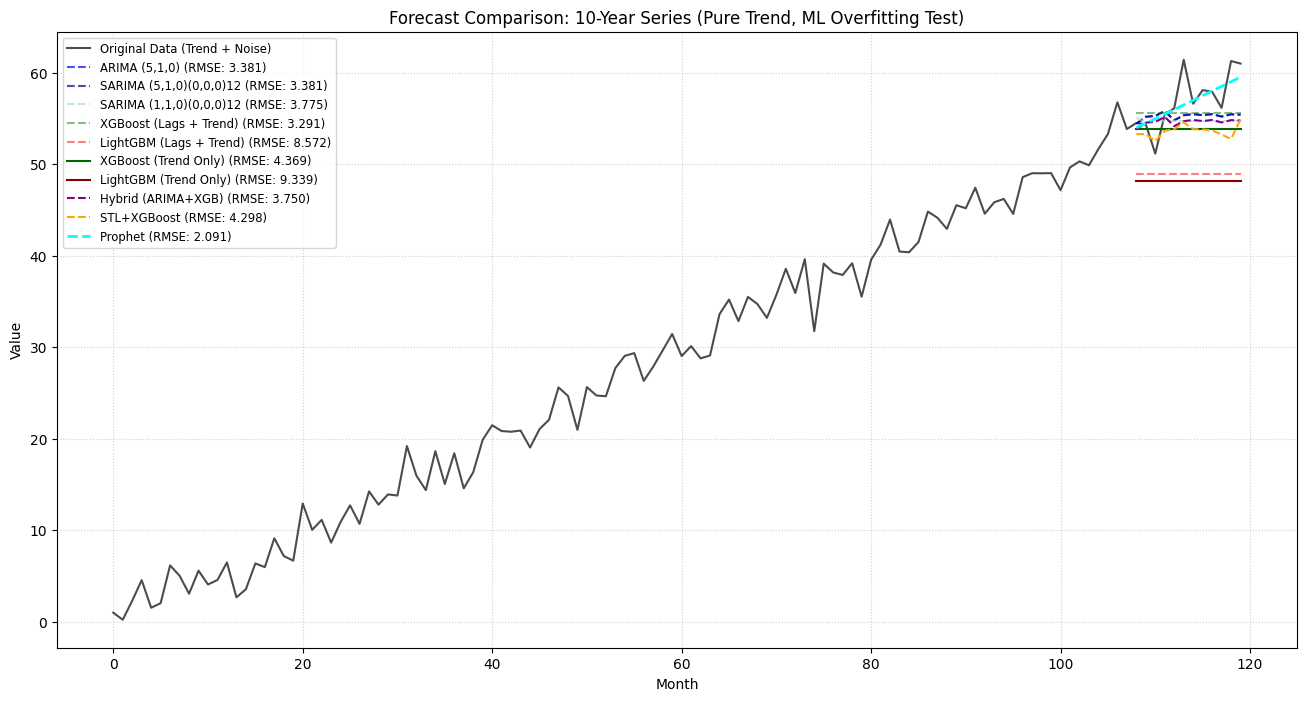


--- 10-Year Series RMSE Scores (Pure Trend, ML Overfitting Test) ---
Prophet RMSE: 2.091
XGBoost (Lags + Trend) RMSE: 3.291
ARIMA (5,1,0) RMSE: 3.381
SARIMA (5,1,0)(0,0,0)12 RMSE: 3.381
Hybrid (ARIMA+XGB) RMSE: 3.750
SARIMA (1,1,0)(0,0,0)12 RMSE: 3.775
STL+XGBoost RMSE: 4.298
XGBoost (Trend Only) RMSE: 4.369
LightGBM (Lags + Trend) RMSE: 8.572
LightGBM (Trend Only) RMSE: 9.339
----------------------------------------

Starting comparison for 20-year series...


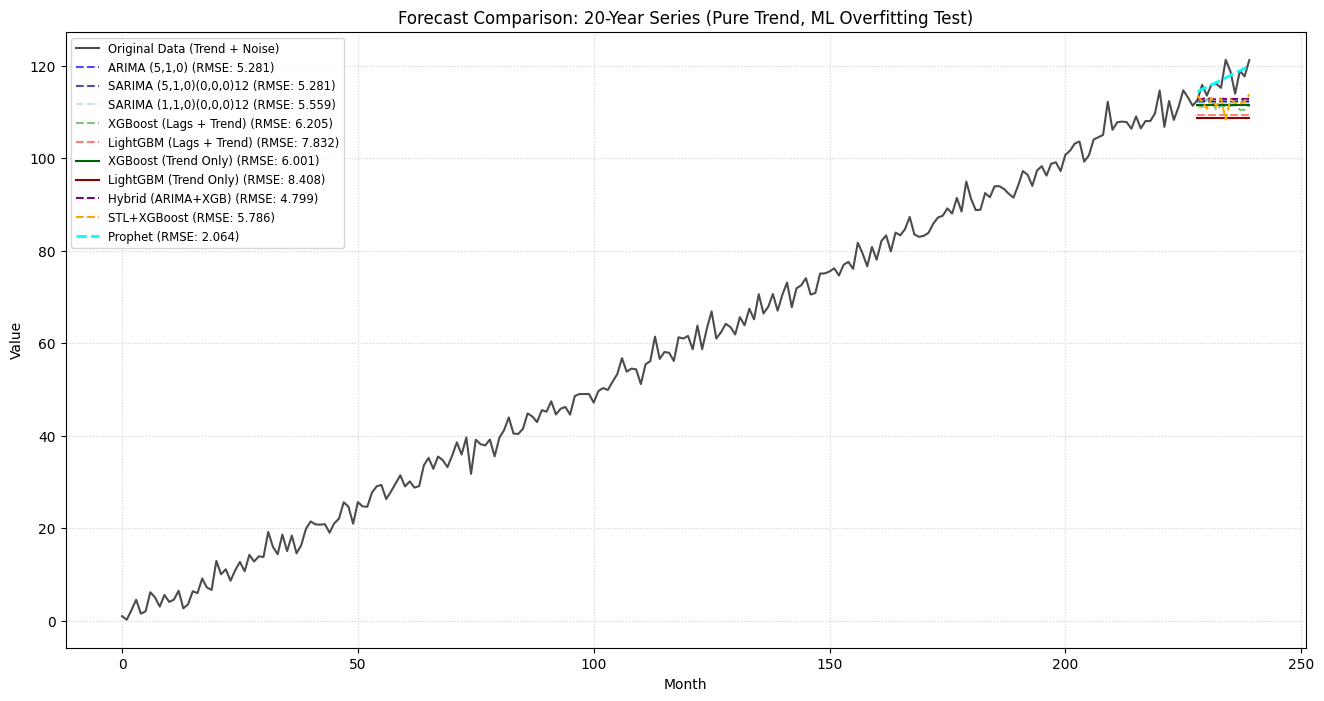


--- 20-Year Series RMSE Scores (Pure Trend, ML Overfitting Test) ---
Prophet RMSE: 2.064
Hybrid (ARIMA+XGB) RMSE: 4.799
ARIMA (5,1,0) RMSE: 5.281
SARIMA (5,1,0)(0,0,0)12 RMSE: 5.281
SARIMA (1,1,0)(0,0,0)12 RMSE: 5.559
STL+XGBoost RMSE: 5.786
XGBoost (Trend Only) RMSE: 6.001
XGBoost (Lags + Trend) RMSE: 6.205
LightGBM (Lags + Trend) RMSE: 7.832
LightGBM (Trend Only) RMSE: 8.408
----------------------------------------


{'ARIMA (5,1,0)': np.float64(5.281319419803174),
 'SARIMA (5,1,0)(0,0,0)12': np.float64(5.281319419803174),
 'SARIMA (1,1,0)(0,0,0)12': np.float64(5.558718233044538),
 'XGBoost (Lags + Trend)': np.float64(6.204586416334109),
 'LightGBM (Lags + Trend)': np.float64(7.8322382743095575),
 'XGBoost (Trend Only)': np.float64(6.001323350219272),
 'LightGBM (Trend Only)': np.float64(8.408210778817903),
 'Hybrid (ARIMA+XGB)': np.float64(4.799193886224823),
 'STL+XGBoost': np.float64(5.785908097268619),
 'Prophet': np.float64(2.0641426208909963)}

In [53]:
# Install necessary libraries (uncomment if running outside an environment where they are pre-installed)
# !pip install prophet lightgbm xgboost statsmodels scikit-learn matplotlib pandas numpy --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


# ----------------- 1. Data Generation (Pure Trend) -----------------
def generate_pure_trend_data(n_years, seed=42):
    """
    Generates synthetic time series data consisting only of a linear trend and noise.
    No seasonal component is included.
    """
    np.random.seed(seed)
    months = n_years * 12
    time = np.arange(months)

    # Simple linear trend (0.5 increase per month)
    trend = 0.5 * time

    # Gaussian noise
    noise = np.random.normal(0, 2, months) # Standard deviation (sigma) = 2

    # Final series is Trend + Noise
    y = trend + noise
    return pd.DataFrame({'month': time, 'y': y})


# ----------------- 2. Utility: Lag Features -----------------
def create_lag_features(df, lags=12):
    """
    Creates lagged features and adds the 'time_index' as an explicit feature.
    """
    series = df['y']
    df_lags = pd.DataFrame(index=df.index)

    # Add the explicit time index (trend feature)
    df_lags['time_index'] = df['month']

    # Add lag features
    for i in range(1, lags + 1):
        df_lags[f'lag_{i}'] = series.shift(i)

    df_lags['y'] = series
    df_lags.dropna(inplace=True)
    return df_lags

def create_lag_features_only(series, lags=12):
    """
    Utility function to create only lag features (used for residual modeling).
    """
    df_lags = pd.DataFrame()
    for i in range(1, lags + 1):
        df_lags[f'lag_{i}'] = series.shift(i)
    df_lags['y'] = series
    df_lags.dropna(inplace=True)
    return df_lags


# ----------------- 3. Forecasting Function -----------------
def compare_models_extended(df, n_train_years, title_suffix):
    """
    Splits data, trains six different forecasting models, calculates RMSE, and plots the results.
    """
    total_months = len(df)
    train_size = n_train_years * 12
    test_size = total_months - train_size

    # Ensure there is enough data for testing and lagging
    if train_size <= 12 or test_size < 1:
        print(f"Error: Not enough data for training or testing with {n_train_years} years of training.")
        return

    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    results = {}

    # --- Setup for ML Models (Lags + TIME_INDEX) ---
    df_lags = create_lag_features(df, lags=12)

    df_train_lags = df_lags[df_lags.index < train_size]
    df_test_lags = df_lags[df_lags.index >= train_size]

    X_train = df_train_lags.drop('y', axis=1)
    y_train = df_train_lags['y']
    X_test = df_test_lags.drop('y', axis=1)
    y_test = df_test_lags['y']

    # Scale features for the 'Lags + Trend' models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- Setup for ML Models (Trend ONLY) ---
    # These models use only the unscaled 'time_index' feature to act as simple trend estimators.
    X_train_trend = X_train[['time_index']]
    X_test_trend = X_test[['time_index']]

    # ----------------- ARIMA -----------------
    arima_model = ARIMA(train['y'], order=(5, 1, 0))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(test))
    results['ARIMA (5,1,0)'] = np.sqrt(mean_squared_error(test['y'], arima_forecast))

    # ----------------- SARIMA (Non-seasonal variants) -----------------
    # 1. SARIMA(5,1,0)(0,0,0)12 - Equivalent to ARIMA(5,1,0)
    sarima_model_510 = SARIMAX(train['y'], order=(5, 1, 0), seasonal_order=(0, 0, 0, 12))
    sarima_fit_510 = sarima_model_510.fit(disp=False)
    sarima_forecast_510 = sarima_fit_510.get_prediction(start=len(train), end=len(df)-1).predicted_mean
    results['SARIMA (5,1,0)(0,0,0)12'] = np.sqrt(mean_squared_error(test['y'], sarima_forecast_510))

    # 2. SARIMA(1,1,0)(0,0,0)12 - Simpler AR(1) on differenced data
    sarima_model_110 = SARIMAX(train['y'], order=(1, 1, 0), seasonal_order=(0, 0, 0, 12))
    sarima_fit_110 = sarima_model_110.fit(disp=False)
    sarima_forecast_110 = sarima_fit_110.get_prediction(start=len(train), end=len(df)-1).predicted_mean
    results['SARIMA (1,1,0)(0,0,0)12'] = np.sqrt(mean_squared_error(test['y'], sarima_forecast_110))

    # ----------------- XGBoost (Lags + Trend) -----------------
    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)
    xgb_forecast = xgb_model.predict(X_test_scaled)
    results['XGBoost (Lags + Trend)'] = np.sqrt(mean_squared_error(y_test, xgb_forecast))

    # ----------------- LightGBM (Lags + Trend) -----------------
    lgb_model = LGBMRegressor(n_estimators=200, random_state=42, verbose=-1)
    lgb_model.fit(X_train_scaled, y_train)
    lgb_forecast = lgb_model.predict(X_test_scaled)
    results['LightGBM (Lags + Trend)'] = np.sqrt(mean_squared_error(y_test, lgb_forecast))

    # ----------------- XGBoost (Trend ONLY) -----------------
    # This model is forced to ignore noisy lags and learn only the linear trend
    xgb_trend_model = XGBRegressor(objective='reg:squarederror', n_estimators=50, random_state=42)
    xgb_trend_model.fit(X_train_trend, y_train)
    xgb_trend_forecast = xgb_trend_model.predict(X_test_trend)
    results['XGBoost (Trend Only)'] = np.sqrt(mean_squared_error(y_test, xgb_trend_forecast))

    # ----------------- LightGBM (Trend ONLY) -----------------
    # This model is forced to ignore noisy lags and learn only the linear trend
    lgb_trend_model = LGBMRegressor(n_estimators=50, random_state=42, verbose=-1)
    lgb_trend_model.fit(X_train_trend, y_train)
    lgb_trend_forecast = lgb_trend_model.predict(X_test_trend)
    results['LightGBM (Trend Only)'] = np.sqrt(mean_squared_error(y_test, lgb_trend_forecast))


    # ----------------- Hybrid ARIMA + XGBoost Residuals -----------------
    arima_pred_train = arima_fit.fittedvalues
    residuals = train['y'].iloc[1:] - arima_pred_train

    df_resid = create_lag_features(pd.DataFrame({'y': residuals, 'month': residuals.index}), lags=12)
    X_resid_train = df_resid.drop('y', axis=1).drop('time_index', axis=1)
    y_resid_train = df_resid['y']

    combined_series = pd.concat([train['y'], test['y']])
    df_resid_test_raw = create_lag_features_only(combined_series, lags=12)
    df_resid_test = df_resid_test_raw.iloc[train_size - 12:train_size - 12 + len(test)].drop('y', axis=1)
    X_resid_test = df_resid_test

    scaler_resid = StandardScaler()
    X_resid_train_scaled = scaler_resid.fit_transform(X_resid_train)
    X_resid_test_scaled = scaler_resid.transform(X_resid_test)

    xgb_resid_model = XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
    xgb_resid_model.fit(X_resid_train_scaled, y_resid_train)
    resid_forecast = xgb_resid_model.predict(X_resid_test_scaled)

    hybrid_forecast = arima_forecast.values + resid_forecast
    results['Hybrid (ARIMA+XGB)'] = np.sqrt(mean_squared_error(test['y'], hybrid_forecast))

    # ----------------- STL + XGBoost -----------------
    stl = STL(train['y'], period=12, robust=True)
    res = stl.fit()

    trend = res.trend.dropna()
    resid = res.resid.dropna()

    df_resid_stl = create_lag_features_only(resid, lags=12)
    X_train_stl = df_resid_stl.drop('y', axis=1)
    y_train_stl = df_resid_stl['y']

    combined_series_for_stl = pd.concat([train['y'], test['y']])
    stl_combined = STL(combined_series_for_stl, period=12, robust=True).fit()
    resid_combined = stl_combined.resid.dropna()
    df_resid_test_stl = create_lag_features_only(resid_combined, lags=12)

    df_resid_test_stl_window = df_resid_test_stl.iloc[train_size - 12 : train_size - 12 + len(test)]
    X_test_stl = df_resid_test_stl_window.drop('y', axis=1)

    scaler_stl = StandardScaler()
    X_train_stl_scaled = scaler_stl.fit_transform(X_train_stl)
    X_test_stl_scaled = scaler_stl.transform(X_test_stl)

    xgb_stl_model = XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
    xgb_stl_model.fit(X_train_stl_scaled, y_train_stl)
    resid_forecast_stl = xgb_stl_model.predict(X_test_stl_scaled)

    trend_forecast = np.full(len(test), trend.iloc[-1])

    stl_forecast = trend_forecast + resid_forecast_stl
    results['STL+XGBoost'] = np.sqrt(mean_squared_error(test['y'], stl_forecast))

    # ----------------- Prophet -----------------
    prophet_train = pd.DataFrame({
        'ds': pd.date_range(start='2000-01-01', periods=len(train), freq='MS'),
        'y': train['y'].values
    })

    prophet_model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        stan_backend=None
    )
    prophet_model.fit(prophet_train)

    future = prophet_model.make_future_dataframe(periods=len(test), freq='MS')
    forecast = prophet_model.predict(future)
    prophet_forecast = forecast['yhat'].iloc[-len(test):].values
    results['Prophet'] = np.sqrt(mean_squared_error(test['y'], prophet_forecast))

    # ----------------- Plot -----------------
    plt.figure(figsize=(16, 8))
    plt.plot(df['month'], df['y'], label='Original Data (Trend + Noise)', color='black', alpha=0.7)

    # Plot forecasts
    plt.plot(test['month'], arima_forecast, label=f'ARIMA (5,1,0) (RMSE: {results["ARIMA (5,1,0)"]:.3f})', linestyle='--', color='blue', alpha=0.7)
    plt.plot(test['month'], sarima_forecast_510, label=f'SARIMA (5,1,0)(0,0,0)12 (RMSE: {results["SARIMA (5,1,0)(0,0,0)12"]:.3f})', linestyle='--', color='darkblue', alpha=0.7)
    plt.plot(test['month'], sarima_forecast_110, label=f'SARIMA (1,1,0)(0,0,0)12 (RMSE: {results["SARIMA (1,1,0)(0,0,0)12"]:.3f})', linestyle='--', color='lightblue', alpha=0.7)

    # Lags + Trend (Original setup, which struggled)
    plt.plot(test['month'], xgb_forecast, label=f'XGBoost (Lags + Trend) (RMSE: {results["XGBoost (Lags + Trend)"]:.3f})', linestyle='--', color='green', alpha=0.5)
    plt.plot(test['month'], lgb_forecast, label=f'LightGBM (Lags + Trend) (RMSE: {results["LightGBM (Lags + Trend)"]:.3f})', linestyle='--', color='red', alpha=0.5)

    # Trend ONLY (The test for overfitting)
    plt.plot(test['month'], xgb_trend_forecast, label=f'XGBoost (Trend Only) (RMSE: {results["XGBoost (Trend Only)"]:.3f})', linestyle='-', color='darkgreen')
    plt.plot(test['month'], lgb_trend_forecast, label=f'LightGBM (Trend Only) (RMSE: {results["LightGBM (Trend Only)"]:.3f})', linestyle='-', color='darkred')

    plt.plot(test['month'], hybrid_forecast, label=f'Hybrid (ARIMA+XGB) (RMSE: {results["Hybrid (ARIMA+XGB)"]:.3f})', linestyle='--', color='purple')
    plt.plot(test['month'], stl_forecast, label=f'STL+XGBoost (RMSE: {results["STL+XGBoost"]:.3f})', linestyle='--', color='orange')
    plt.plot(test['month'], prophet_forecast, label=f'Prophet (RMSE: {results["Prophet"]:.3f})', linestyle='--', color='cyan', linewidth=2)

    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.title(f'Forecast Comparison: {title_suffix} (Pure Trend, ML Overfitting Test)')
    plt.legend(loc='upper left', fontsize='small')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

    print(f"\n--- {title_suffix} RMSE Scores (Pure Trend, ML Overfitting Test) ---")
    for model, rmse in sorted(results.items(), key=lambda item: item[1]):
        print(f"{model} RMSE: {rmse:.3f}")
    print("-" * 40)

    return results

# ----------------- 4. Run for 10-year and 20-year series -----------------
print("Starting comparison for 10-year series...")
df_10y = generate_pure_trend_data(10)
compare_models_extended(df_10y, n_train_years=9, title_suffix="10-Year Series")

print("\nStarting comparison for 20-year series...")
df_20y = generate_pure_trend_data(20)
compare_models_extended(df_20y, n_train_years=19, title_suffix="20-Year Series")